# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
# importamos las librerias necesarias
import os 
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('./Dataset/Segundoparcialv8icoco-mmdetection/') # Path del dataset
images_train = [path/'train'/i for i in os.listdir(path/'train')] # path de las imagenes de entrenamiento
mascaras_train = [path/'trainmasks'/i for i in os.listdir(path/'trainmasks')] # path de las mascaras de entrenamiento
images_test = [path/'test'/i for i in os.listdir(path/'test')] # path de las imagenes de test
mascaras_test = [path/'testmasks'/i for i in os.listdir(path/'testmasks')] # path de las mascaras de test

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [2]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.
        
        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)
        
        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)
    
    return np.array(imagenes), np.array(mascaras)

In [3]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (100, 512, 512, 3)
Forma de las máscaras numpy: (100, 512, 512, 4)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [4]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [5]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((512, 512, 3), (512, 512, 4))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

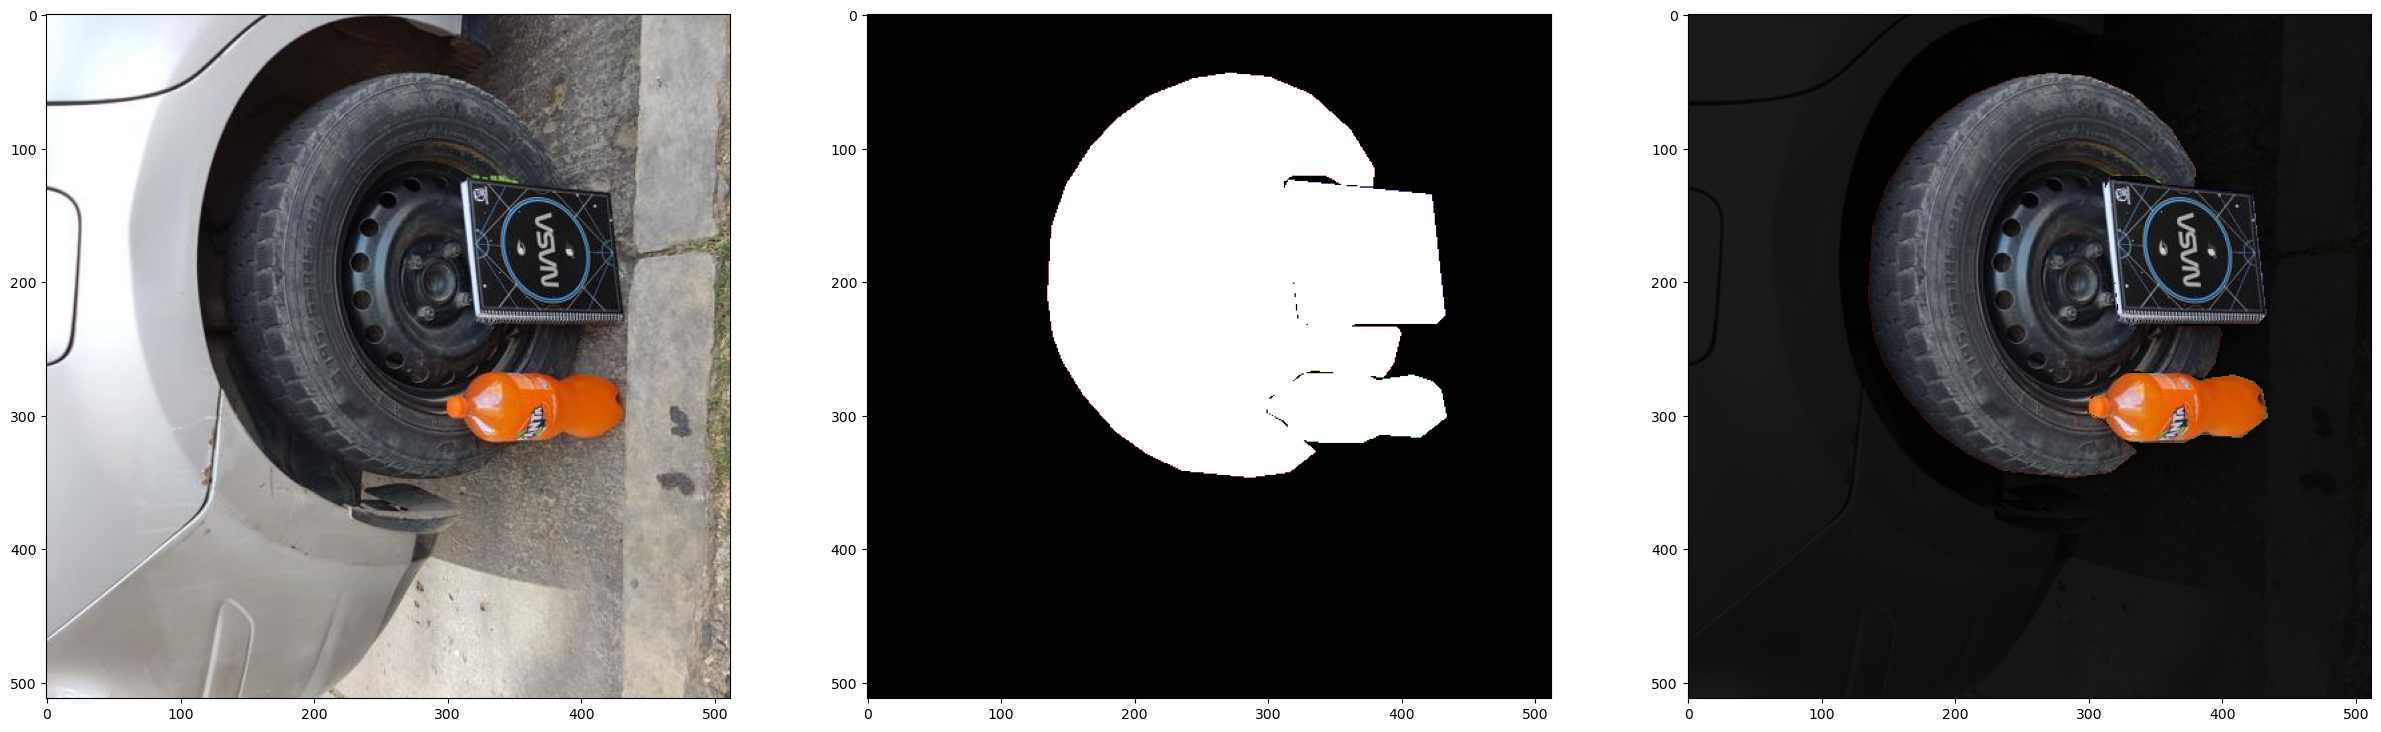

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = imgs[78]
mask = masks[78]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.9)
plt.show()

In [8]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((512, 512, 3), dtype('float64'), 1.0, 0.0)

In [9]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((512, 512, 4), dtype('float64'), 1.0, 0.0)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [10]:
import torch.nn.functional as F
import torch

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# funcion encoder
def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# clase UNet
class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        #print(x.shape, x3.shape, x2.shape, x1.shape)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

Hacemos las pruebas para ver que todo está bien.

In [10]:
model = UNet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 4, 512, 512])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [12]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 4, 512, 512]))

In [14]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.29153
Epoch 2/50 loss 0.33474
Epoch 3/50 loss 0.28706
Epoch 4/50 loss 0.29010
Epoch 5/50 loss 0.28899
Epoch 6/50 loss 0.28060
Epoch 7/50 loss 0.27262
Epoch 8/50 loss 0.26672
Epoch 9/50 loss 0.26341
Epoch 10/50 loss 0.25809
Epoch 11/50 loss 0.25414
Epoch 12/50 loss 0.25045
Epoch 13/50 loss 0.24612
Epoch 14/50 loss 0.24227
Epoch 15/50 loss 0.23846
Epoch 16/50 loss 0.23436
Epoch 17/50 loss 0.23072
Epoch 18/50 loss 0.22695
Epoch 19/50 loss 0.22308
Epoch 20/50 loss 0.21970
Epoch 21/50 loss 0.21614
Epoch 22/50 loss 0.21280
Epoch 23/50 loss 0.20956
Epoch 24/50 loss 0.20611
Epoch 25/50 loss 0.20291
Epoch 26/50 loss 0.19959
Epoch 27/50 loss 0.19645
Epoch 28/50 loss 0.19343
Epoch 29/50 loss 0.19038
Epoch 30/50 loss 0.18751
Epoch 31/50 loss 0.18458
Epoch 32/50 loss 0.18177
Epoch 33/50 loss 0.17903
Epoch 34/50 loss 0.17630
Epoch 35/50 loss 0.17371
Epoch 36/50 loss 0.17108
Epoch 37/50 loss 0.16855
Epoch 38/50 loss 0.16604
Epoch 39/50 loss 0.16360
Epoch 40/50 loss 0.16125
Epoch 41/

Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

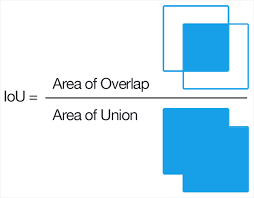

In [11]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [18]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.00291 iou 0.99070
Epoch 2/100 loss 0.29170 iou 0.80580
Epoch 3/100 loss 0.05738 iou 0.92250
Epoch 4/100 loss 0.02662 iou 0.94368
Epoch 5/100 loss 0.06459 iou 0.92565
Epoch 6/100 loss 0.03952 iou 0.93671
Epoch 7/100 loss 0.02158 iou 0.94336
Epoch 8/100 loss 0.01746 iou 0.94892
Epoch 9/100 loss 0.02246 iou 0.94376
Epoch 10/100 loss 0.02295 iou 0.94496
Epoch 11/100 loss 0.01836 iou 0.95312
Epoch 12/100 loss 0.01391 iou 0.96209
Epoch 13/100 loss 0.01300 iou 0.96163
Epoch 14/100 loss 0.01300 iou 0.96194
Epoch 15/100 loss 0.01174 iou 0.96284
Epoch 16/100 loss 0.01038 iou 0.96478
Epoch 17/100 loss 0.00993 iou 0.96616
Epoch 18/100 loss 0.01002 iou 0.96729
Epoch 19/100 loss 0.00986 iou 0.96844
Epoch 20/100 loss 0.00916 iou 0.97162
Epoch 21/100 loss 0.00839 iou 0.97419
Epoch 22/100 loss 0.00804 iou 0.97517
Epoch 23/100 loss 0.00784 iou 0.97511
Epoch 24/100 loss 0.00761 iou 0.97427
Epoch 25/100 loss 0.00728 iou 0.97462
Epoch 26/100 loss 0.00688 iou 0.97571
Epoch 27/100 loss 0.0

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

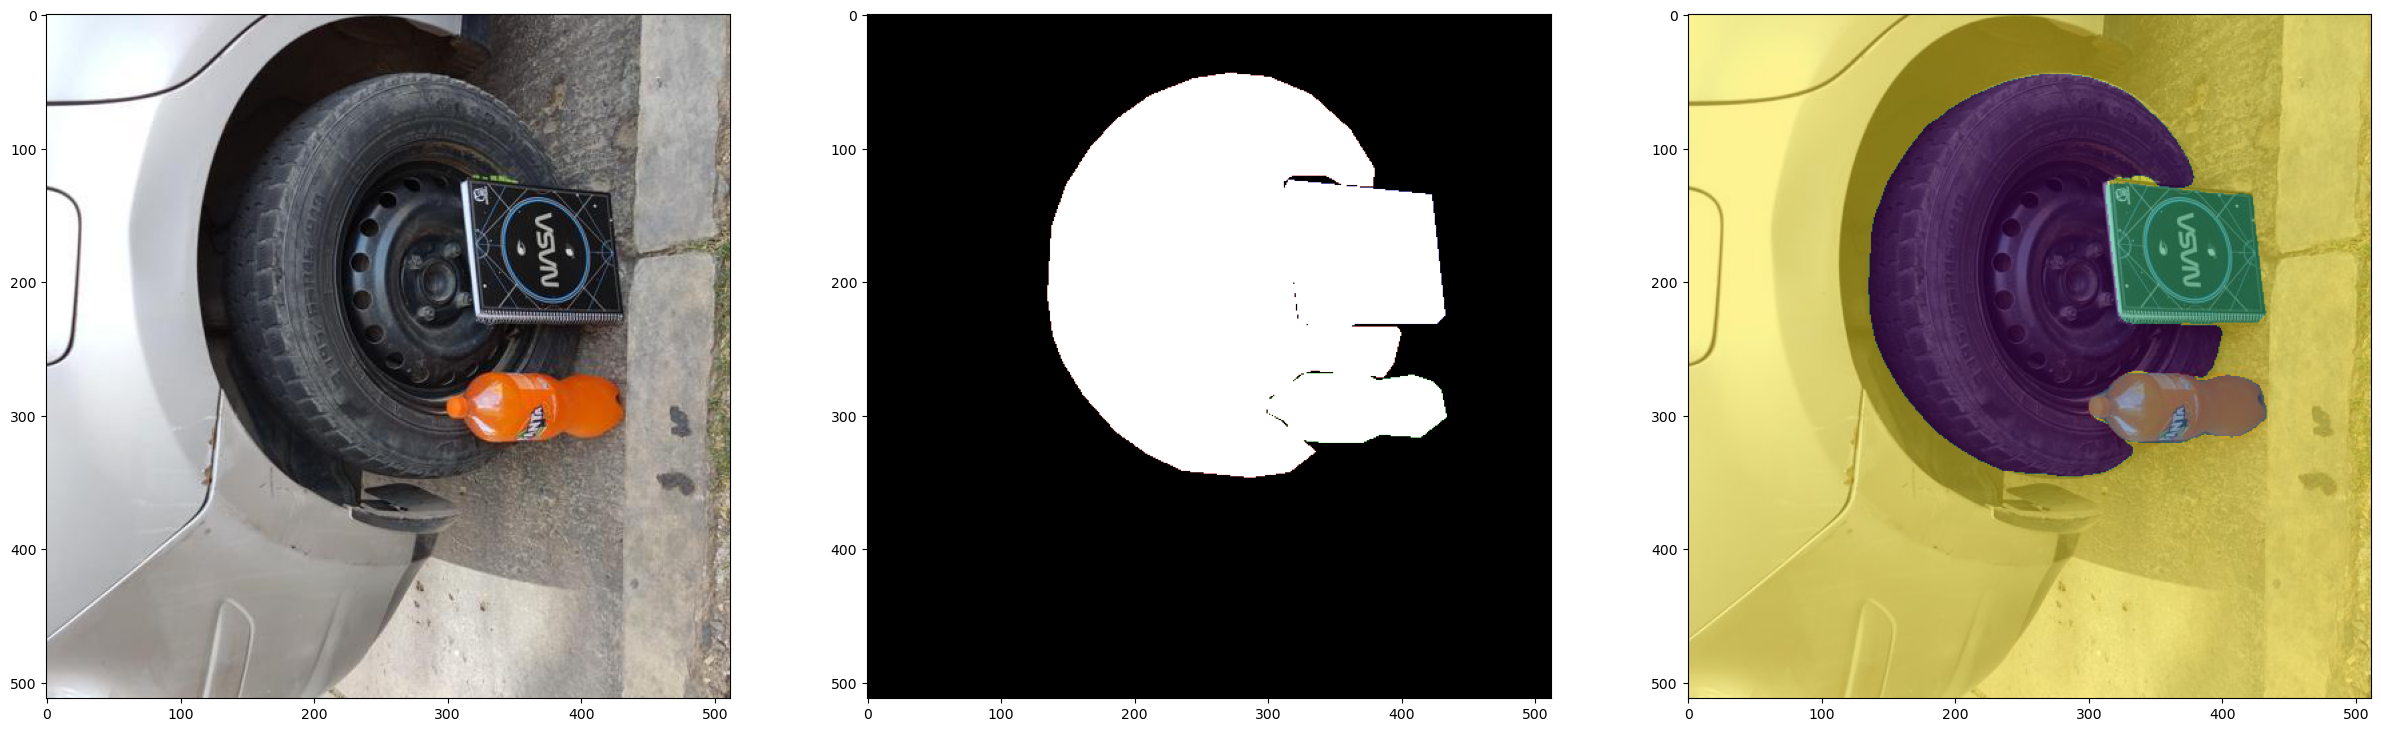

In [19]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.5)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [12]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [13]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(993, 100)

In [14]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 512, 512]), torch.Size([4, 512, 512]))

In [15]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 4, 512, 512]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [23]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"./models/UNetResNet_model_seg_v2_{epoch}.pt")
        
    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente. 

In [27]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/63 [00:00<?, ?it/s]

test_loss 0.40130 test_iou 0.14717: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]



Epoch 1/30 loss 0.56542 iou 0.05653 test_loss 0.40130 test_iou 0.14717


test_loss 0.28643 test_iou 0.49628: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]



Epoch 2/30 loss 0.36689 iou 0.37137 test_loss 0.28643 test_iou 0.49628


test_loss 0.26403 test_iou 0.54506: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Epoch 3/30 loss 0.30556 iou 0.49752 test_loss 0.26403 test_iou 0.54506


test_loss 0.27370 test_iou 0.52798: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 4/30 loss 0.29030 iou 0.50269 test_loss 0.27370 test_iou 0.52798


test_loss 0.24829 test_iou 0.46343: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 5/30 loss 0.27287 iou 0.45778 test_loss 0.24829 test_iou 0.46343


test_loss 0.22605 test_iou 0.46258: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Epoch 6/30 loss 0.26485 iou 0.45249 test_loss 0.22605 test_iou 0.46258


test_loss 0.22450 test_iou 0.46331: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 7/30 loss 0.25498 iou 0.45403 test_loss 0.22450 test_iou 0.46331


test_loss 0.23835 test_iou 0.38280: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 8/30 loss 0.25537 iou 0.44786 test_loss 0.23835 test_iou 0.38280


test_loss 0.21865 test_iou 0.41845: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Epoch 9/30 loss 0.25602 iou 0.44962 test_loss 0.21865 test_iou 0.41845


test_loss 0.20950 test_iou 0.45465: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 10/30 loss 0.24541 iou 0.44765 test_loss 0.20950 test_iou 0.45465


test_loss 0.22567 test_iou 0.44443: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Epoch 11/30 loss 0.23833 iou 0.45888 test_loss 0.22567 test_iou 0.44443


test_loss 0.21415 test_iou 0.41358: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 12/30 loss 0.23942 iou 0.44728 test_loss 0.21415 test_iou 0.41358


test_loss 0.20316 test_iou 0.39445: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Epoch 13/30 loss 0.23040 iou 0.45725 test_loss 0.20316 test_iou 0.39445


test_loss 0.19749 test_iou 0.41295: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]



Epoch 14/30 loss 0.23014 iou 0.45422 test_loss 0.19749 test_iou 0.41295


test_loss 0.22333 test_iou 0.35781: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 15/30 loss 0.22895 iou 0.46461 test_loss 0.22333 test_iou 0.35781


test_loss 0.20383 test_iou 0.41635: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 16/30 loss 0.23770 iou 0.44750 test_loss 0.20383 test_iou 0.41635


test_loss 0.20956 test_iou 0.42444: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 17/30 loss 0.22356 iou 0.46808 test_loss 0.20956 test_iou 0.42444


test_loss 0.19600 test_iou 0.45822: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 18/30 loss 0.21825 iou 0.46109 test_loss 0.19600 test_iou 0.45822


test_loss 0.19160 test_iou 0.42611: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 19/30 loss 0.21889 iou 0.45118 test_loss 0.19160 test_iou 0.42611


test_loss 0.20090 test_iou 0.44107: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 20/30 loss 0.21266 iou 0.46797 test_loss 0.20090 test_iou 0.44107


test_loss 0.19997 test_iou 0.43290: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 21/30 loss 0.21264 iou 0.44174 test_loss 0.19997 test_iou 0.43290


test_loss 0.18403 test_iou 0.43428: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 22/30 loss 0.20709 iou 0.45914 test_loss 0.18403 test_iou 0.43428


test_loss 0.21411 test_iou 0.36025: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]



Epoch 23/30 loss 0.21540 iou 0.45391 test_loss 0.21411 test_iou 0.36025


test_loss 0.18334 test_iou 0.43212: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 24/30 loss 0.20391 iou 0.40918 test_loss 0.18334 test_iou 0.43212


test_loss 0.18423 test_iou 0.40349: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 25/30 loss 0.20403 iou 0.36582 test_loss 0.18423 test_iou 0.40349


test_loss 0.18678 test_iou 0.41091: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 26/30 loss 0.20855 iou 0.35843 test_loss 0.18678 test_iou 0.41091


test_loss 0.18812 test_iou 0.41982: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 27/30 loss 0.19975 iou 0.35737 test_loss 0.18812 test_iou 0.41982


test_loss 0.17700 test_iou 0.35839: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]



Epoch 28/30 loss 0.19453 iou 0.36402 test_loss 0.17700 test_iou 0.35839


test_loss 0.21741 test_iou 0.37794: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]



Epoch 29/30 loss 0.19091 iou 0.36107 test_loss 0.21741 test_iou 0.37794


test_loss 0.18334 test_iou 0.31628: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch 30/30 loss 0.18727 iou 0.37088 test_loss 0.18334 test_iou 0.31628


Vemos que la precisión de nuestro modelo es bastante bajo lo cual nos indica que el modelo carece de datos o que necesita más tiempo de entrenamiento.

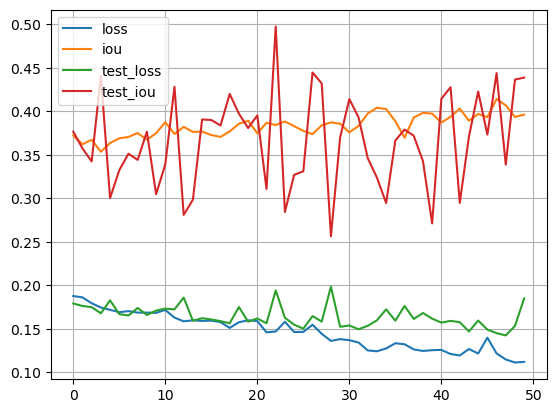

In [36]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [154]:
classes = ['rueda', 'gaseosa', 'cuaderno', 'background']
colors = ['#1f77b4', '#ff9e80', '#8bc34a', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

67


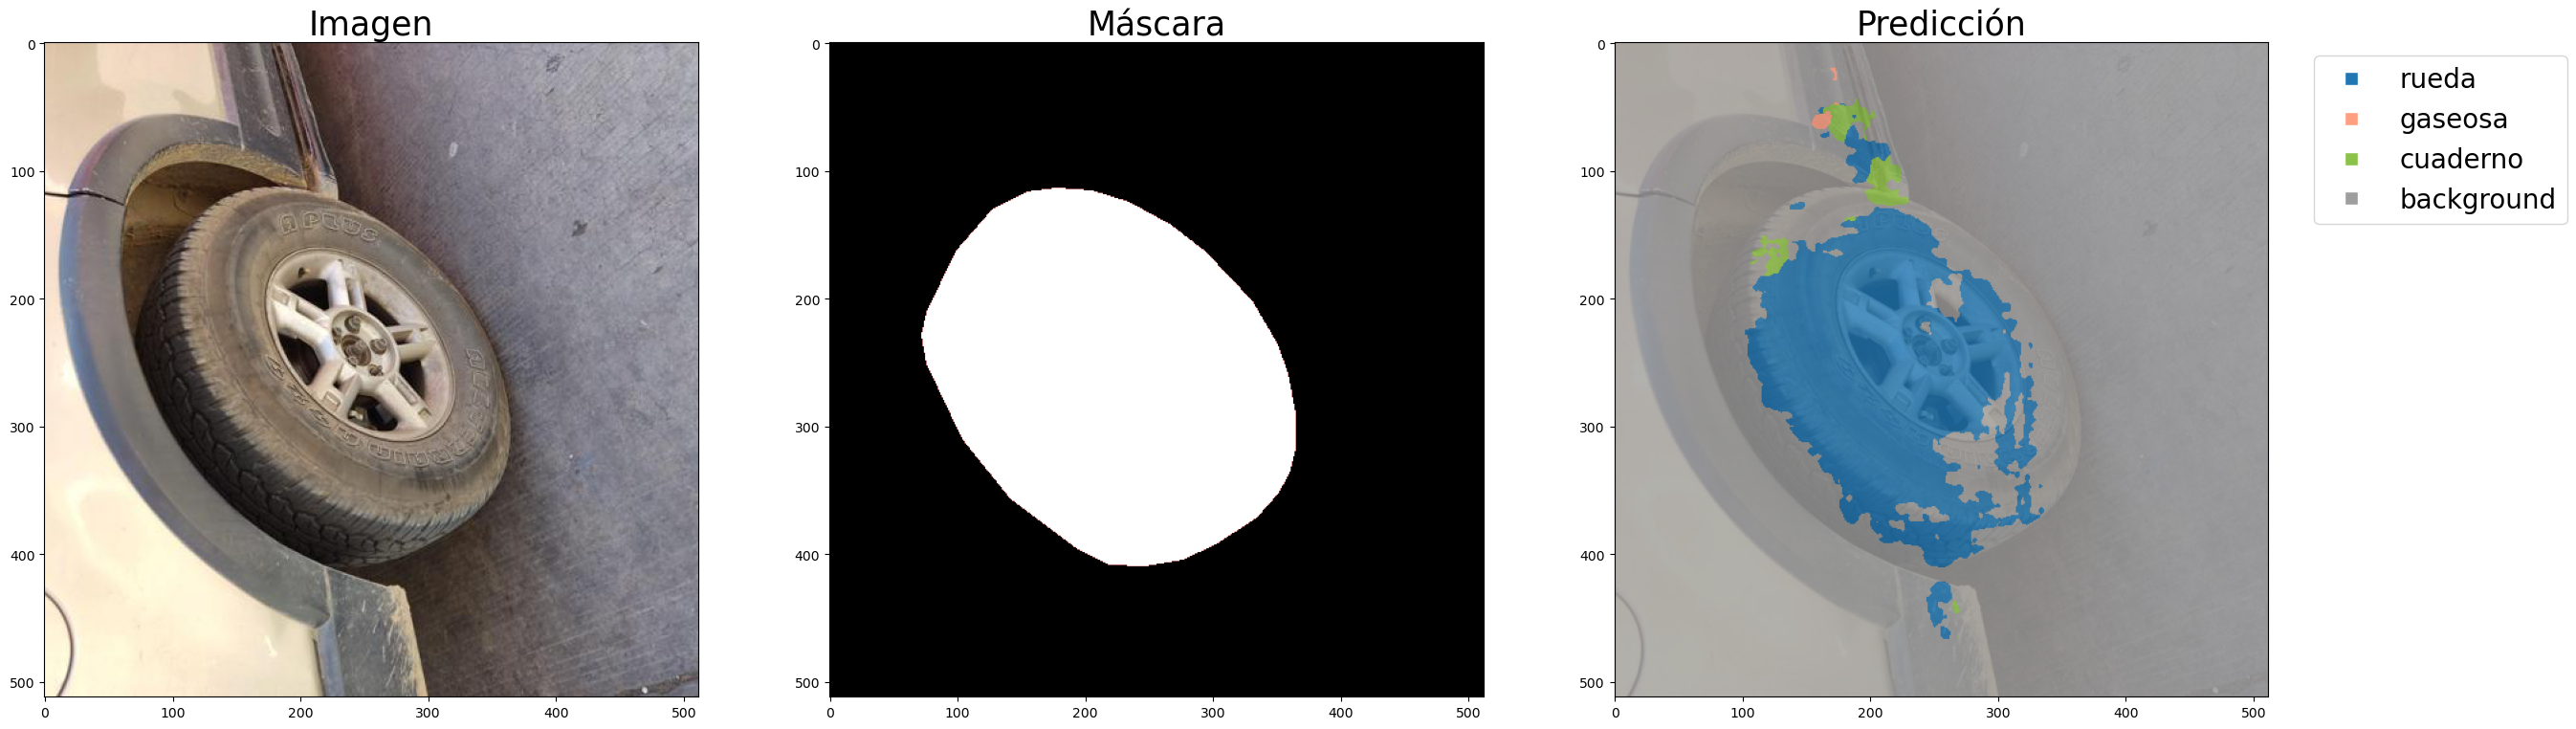

In [173]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [16]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Probamos para ver que todo este correctamente.

In [17]:
model = UNetResnet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 4, 512, 512])

#### Entrenamos el modelo

Procedemos a entrenar el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente.

In [27]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.37937 test_iou 0.43025: 100%|██████████| 4/4 [00:16<00:00,  4.01s/it]



Epoch 1/30 loss 0.47775 iou 0.32901 test_loss 0.37937 test_iou 0.43025


test_loss 0.26123 test_iou 0.56588: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]



Epoch 2/30 loss 0.31482 iou 0.56903 test_loss 0.26123 test_iou 0.56588


test_loss 0.19413 test_iou 0.69399: 100%|██████████| 4/4 [00:15<00:00,  3.78s/it]



Epoch 3/30 loss 0.23240 iou 0.65924 test_loss 0.19413 test_iou 0.69399


test_loss 0.17943 test_iou 0.64177: 100%|██████████| 4/4 [00:14<00:00,  3.74s/it]



Epoch 4/30 loss 0.17437 iou 0.72501 test_loss 0.17943 test_iou 0.64177


test_loss 0.13230 test_iou 0.61227: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]



Epoch 5/30 loss 0.13741 iou 0.75139 test_loss 0.13230 test_iou 0.61227


test_loss 0.12462 test_iou 0.62245: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]



Epoch 6/30 loss 0.10892 iou 0.78055 test_loss 0.12462 test_iou 0.62245


test_loss 0.13727 test_iou 0.61720: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]



Epoch 7/30 loss 0.09074 iou 0.78976 test_loss 0.13727 test_iou 0.61720


test_loss 0.10213 test_iou 0.73959: 100%|██████████| 4/4 [00:15<00:00,  3.78s/it]



Epoch 8/30 loss 0.07491 iou 0.83040 test_loss 0.10213 test_iou 0.73959


test_loss 0.09511 test_iou 0.74957: 100%|██████████| 4/4 [00:15<00:00,  3.85s/it]



Epoch 9/30 loss 0.07357 iou 0.77603 test_loss 0.09511 test_iou 0.74957


test_loss 0.08722 test_iou 0.75560: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]



Epoch 10/30 loss 0.05811 iou 0.83833 test_loss 0.08722 test_iou 0.75560


test_loss 0.07652 test_iou 0.78785: 100%|██████████| 4/4 [00:15<00:00,  3.83s/it]



Epoch 11/30 loss 0.05445 iou 0.82805 test_loss 0.07652 test_iou 0.78785


test_loss 0.07835 test_iou 0.80658: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]



Epoch 12/30 loss 0.05150 iou 0.83855 test_loss 0.07835 test_iou 0.80658


test_loss 0.08089 test_iou 0.62082: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 13/30 loss 0.04621 iou 0.83493 test_loss 0.08089 test_iou 0.62082


test_loss 0.07344 test_iou 0.82619: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 14/30 loss 0.05363 iou 0.80543 test_loss 0.07344 test_iou 0.82619


test_loss 0.09902 test_iou 0.83913: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]



Epoch 15/30 loss 0.03930 iou 0.87106 test_loss 0.09902 test_iou 0.83913


test_loss 0.07916 test_iou 0.80427: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 16/30 loss 0.04945 iou 0.80444 test_loss 0.07916 test_iou 0.80427


test_loss 0.08024 test_iou 0.78407: 100%|██████████| 4/4 [00:15<00:00,  3.79s/it]



Epoch 17/30 loss 0.03764 iou 0.84378 test_loss 0.08024 test_iou 0.78407


test_loss 0.06230 test_iou 0.83295: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]



Epoch 18/30 loss 0.03554 iou 0.86355 test_loss 0.06230 test_iou 0.83295


test_loss 0.07230 test_iou 0.82394: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]



Epoch 19/30 loss 0.03201 iou 0.86160 test_loss 0.07230 test_iou 0.82394


test_loss 0.07151 test_iou 0.81445: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]



Epoch 20/30 loss 0.03194 iou 0.83933 test_loss 0.07151 test_iou 0.81445


test_loss 0.06567 test_iou 0.83836: 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]



Epoch 21/30 loss 0.02033 iou 0.91621 test_loss 0.06567 test_iou 0.83836


test_loss 0.09675 test_iou 0.59660: 100%|██████████| 4/4 [00:15<00:00,  3.79s/it]



Epoch 22/30 loss 0.02388 iou 0.91781 test_loss 0.09675 test_iou 0.59660


test_loss 0.06615 test_iou 0.77114: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 23/30 loss 0.04843 iou 0.80118 test_loss 0.06615 test_iou 0.77114


test_loss 0.06064 test_iou 0.83168: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 24/30 loss 0.02615 iou 0.87467 test_loss 0.06064 test_iou 0.83168


test_loss 0.07703 test_iou 0.87591: 100%|██████████| 4/4 [00:15<00:00,  3.81s/it]



Epoch 25/30 loss 0.02175 iou 0.88981 test_loss 0.07703 test_iou 0.87591


test_loss 0.11142 test_iou 0.80182: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]



Epoch 26/30 loss 0.02046 iou 0.91811 test_loss 0.11142 test_iou 0.80182


test_loss 0.07309 test_iou 0.81314: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]



Epoch 27/30 loss 0.05433 iou 0.77234 test_loss 0.07309 test_iou 0.81314


test_loss 0.09678 test_iou 0.87417: 100%|██████████| 4/4 [00:15<00:00,  4.00s/it]



Epoch 28/30 loss 0.03502 iou 0.85052 test_loss 0.09678 test_iou 0.87417


test_loss 0.06501 test_iou 0.73849: 100%|██████████| 4/4 [00:14<00:00,  3.72s/it]



Epoch 29/30 loss 0.03564 iou 0.84901 test_loss 0.06501 test_iou 0.73849


test_loss 0.06720 test_iou 0.81901: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


Epoch 30/30 loss 0.02765 iou 0.86549 test_loss 0.06720 test_iou 0.81901


Vemos que la precisióon de nuestro modelo mejoró bastante a comparación del modelo anterior llegando a una precisión de `81.90%`.

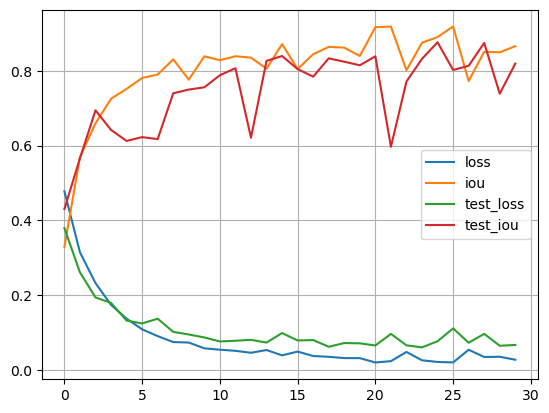

In [28]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

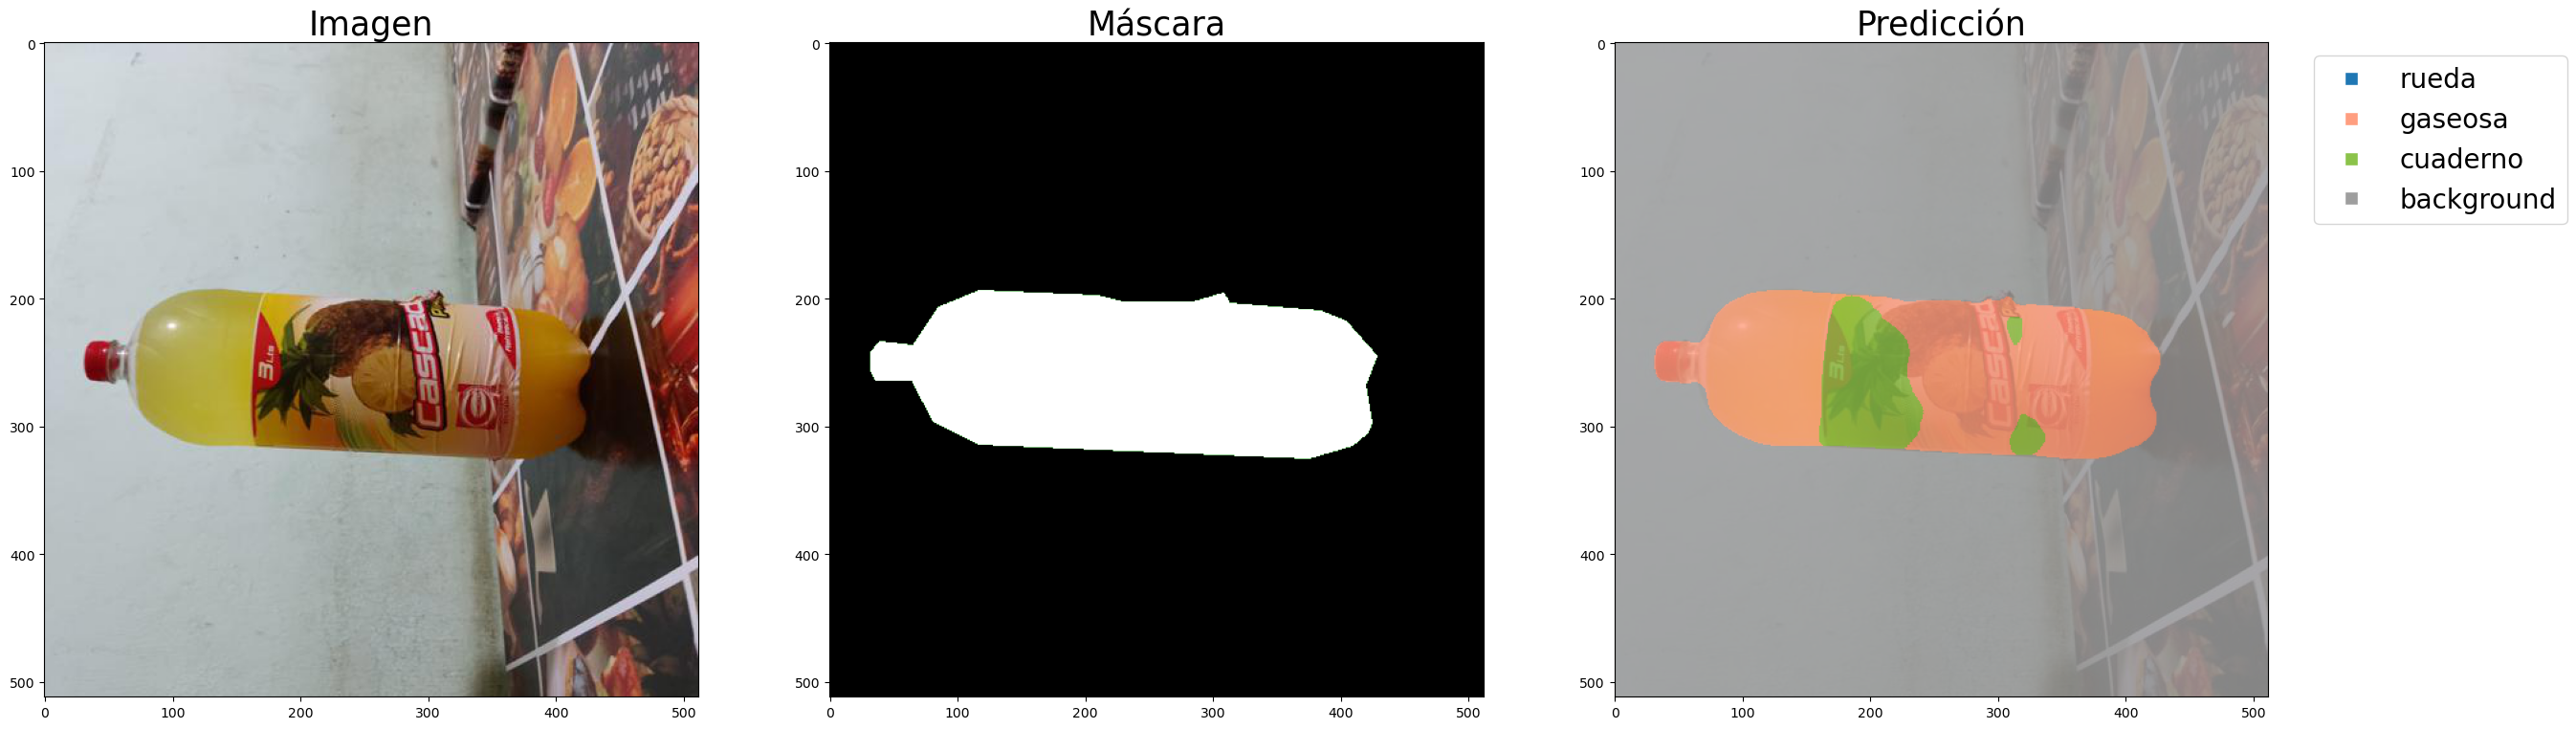

In [188]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

#### Reentrenameinto

Ahora haremos un reentrenamiento del modelo para ver si mejora la precisión del modelo con un `learning rate` más pequeño. Para eso cargaremos el modelo anterior que lo guardamos y procedemos a reentrenarlo. Para ver si se logra algunas mejoras.

In [189]:
# cargar modelo
model = UNetResnet()
model.load_state_dict(torch.load('./models/UNetResNet_model_seg_v1_2.pt'))

<All keys matched successfully>

In [45]:
hist = fit(model, dataloader, epochs=5, lr=3e-5)

test_loss 0.06627 test_iou 0.86475: 100%|██████████| 4/4 [00:15<00:00,  3.99s/it]



Epoch 1/5 loss 0.01569 iou 0.95187 test_loss 0.06627 test_iou 0.86475


test_loss 0.07235 test_iou 0.87808: 100%|██████████| 4/4 [00:16<00:00,  4.00s/it]



Epoch 2/5 loss 0.01935 iou 0.96111 test_loss 0.07235 test_iou 0.87808


test_loss 0.06900 test_iou 0.86297: 100%|██████████| 4/4 [00:15<00:00,  3.97s/it]



Epoch 3/5 loss 0.01851 iou 0.94740 test_loss 0.06900 test_iou 0.86297


test_loss 0.06183 test_iou 0.84399: 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]



Epoch 4/5 loss 0.01717 iou 0.94588 test_loss 0.06183 test_iou 0.84399


test_loss 0.06355 test_iou 0.84772: 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]



Epoch 5/5 loss 0.01476 iou 0.95392 test_loss 0.06355 test_iou 0.84772


Efectivamente, el modelo mejora su precisión a `87.80%` después de reentrarlo con un `learning rate` más pequeño.

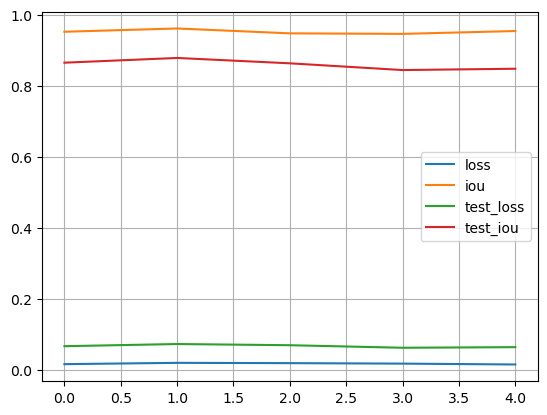

In [46]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

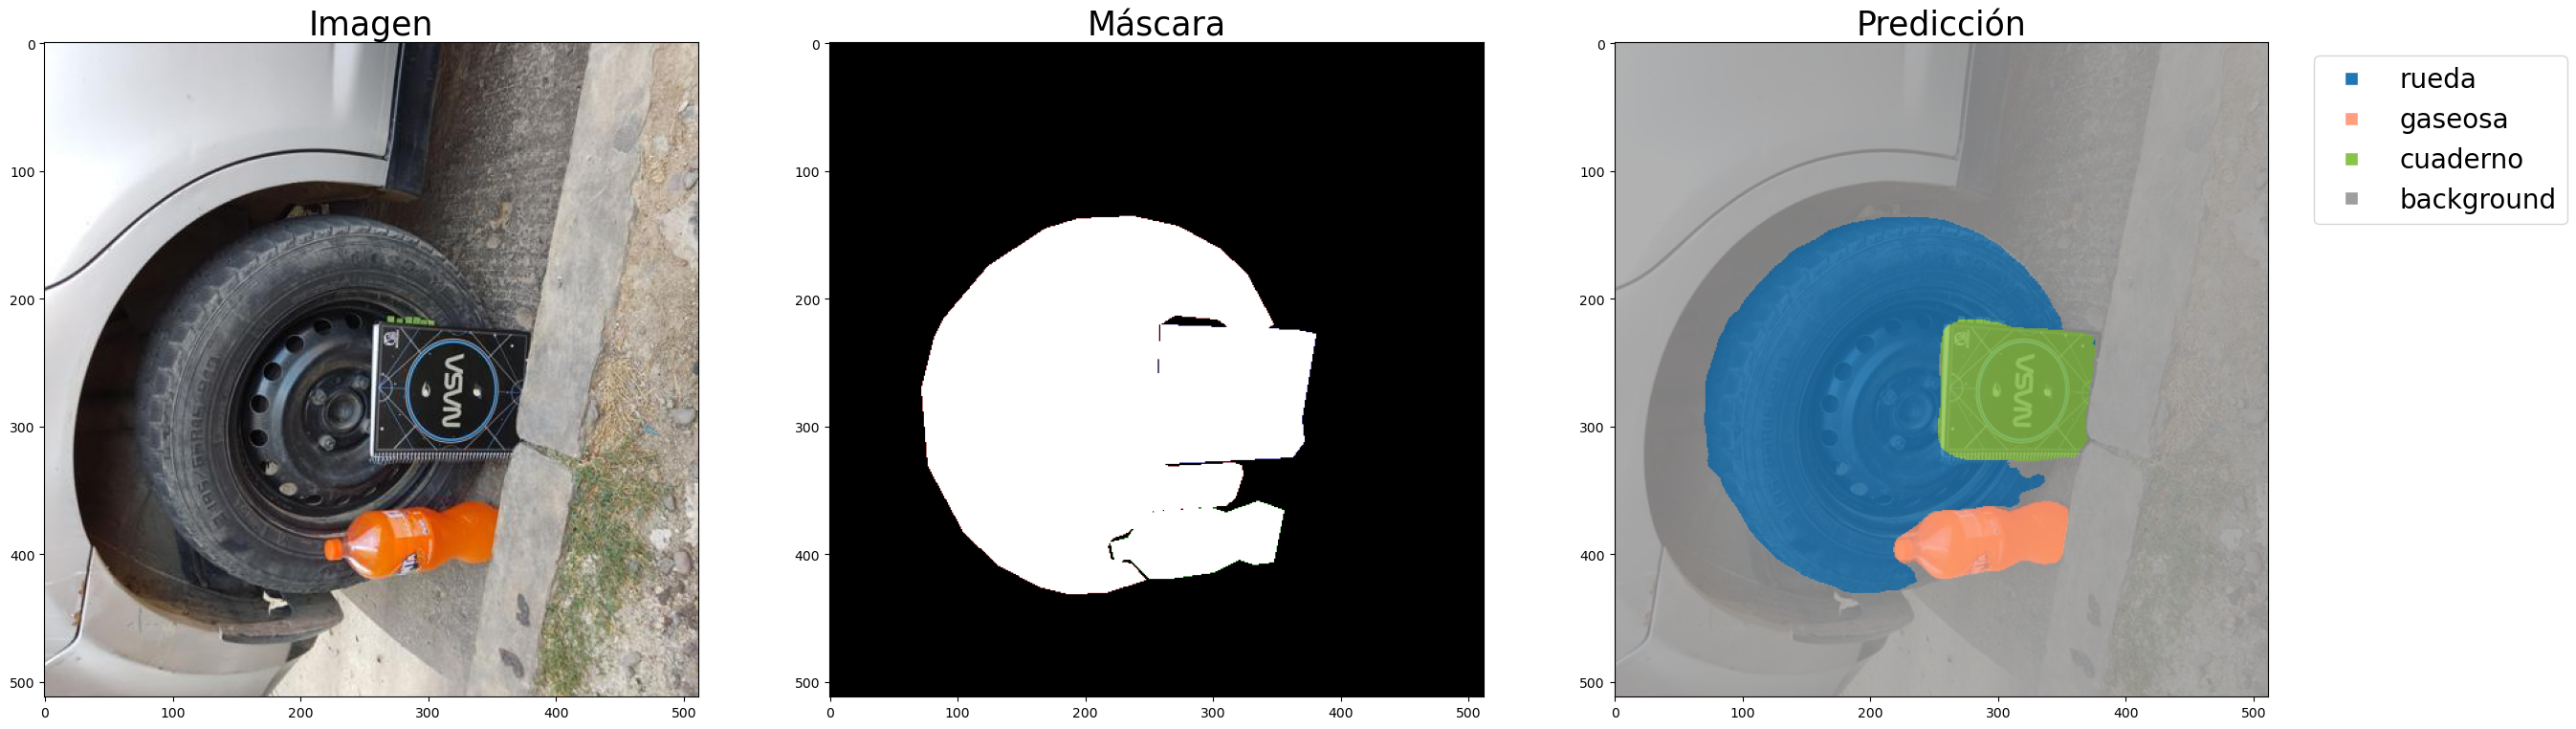

In [204]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)